In [43]:
import os
import numpy as np
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from keras.datasets import imdb
from keras import backend as K
from keras.preprocessing import sequence

In [12]:
data_dir = '../data/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

for i in header:
    print(i)
print(len(lines))

"Date Time"
"p (mbar)"
"T (degC)"
"Tpot (K)"
"Tdew (degC)"
"rh (%)"
"VPmax (mbar)"
"VPact (mbar)"
"VPdef (mbar)"
"sh (g/kg)"
"H2OC (mmol/mol)"
"rho (g/m**3)"
"wv (m/s)"
"max. wv (m/s)"
"wd (deg)"
420551


In [13]:
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values


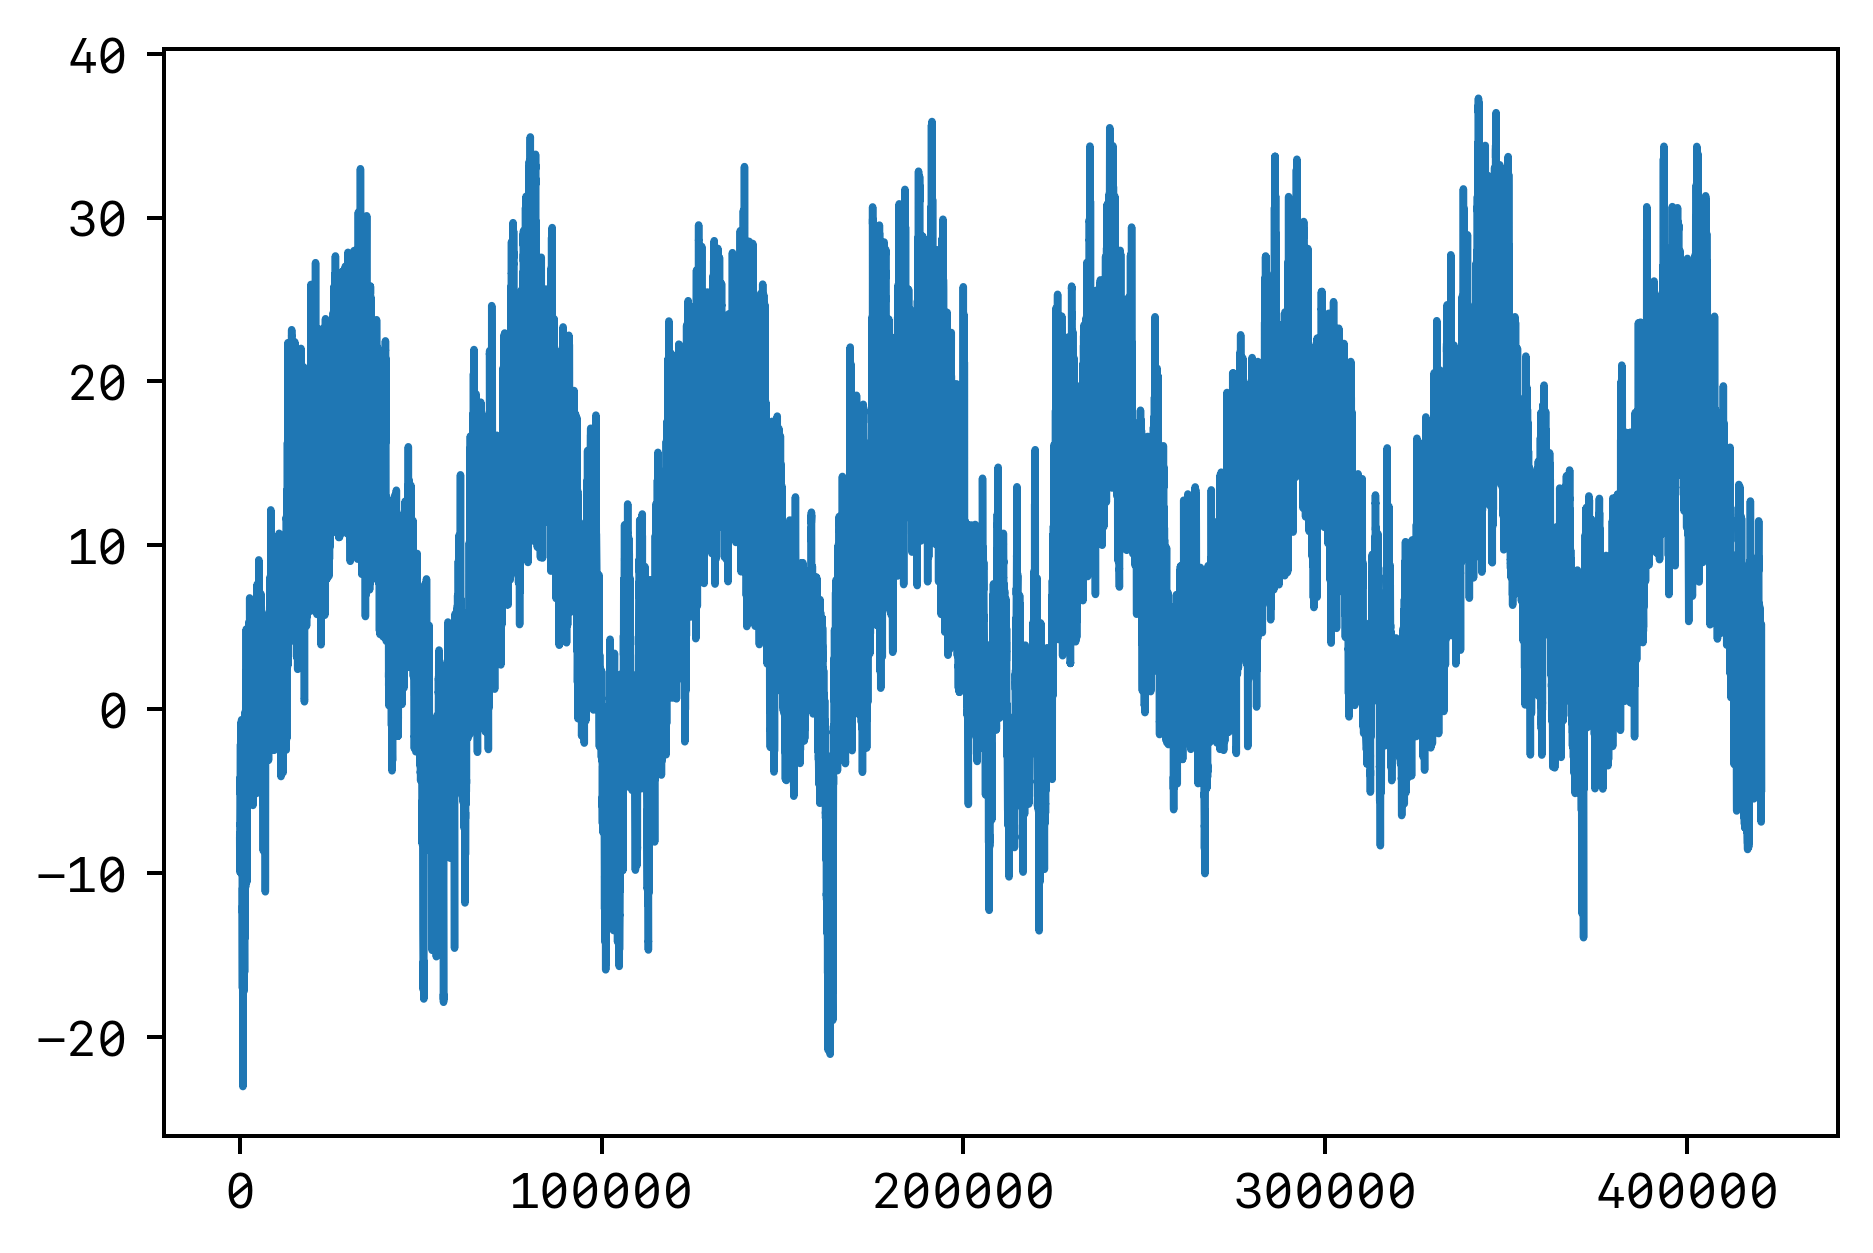

In [14]:
plt.rcParams['font.sans-serif'] = ['SF Mono']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['savefig.dpi'] = 360  #图片像素
plt.rcParams['figure.dpi'] = 360  #分辨率
temp = float_data[:, 1]  # temperature (in degrees Celsius)（温度（单位：摄氏度））
plt.plot(range(len(temp)), temp)
plt.show()

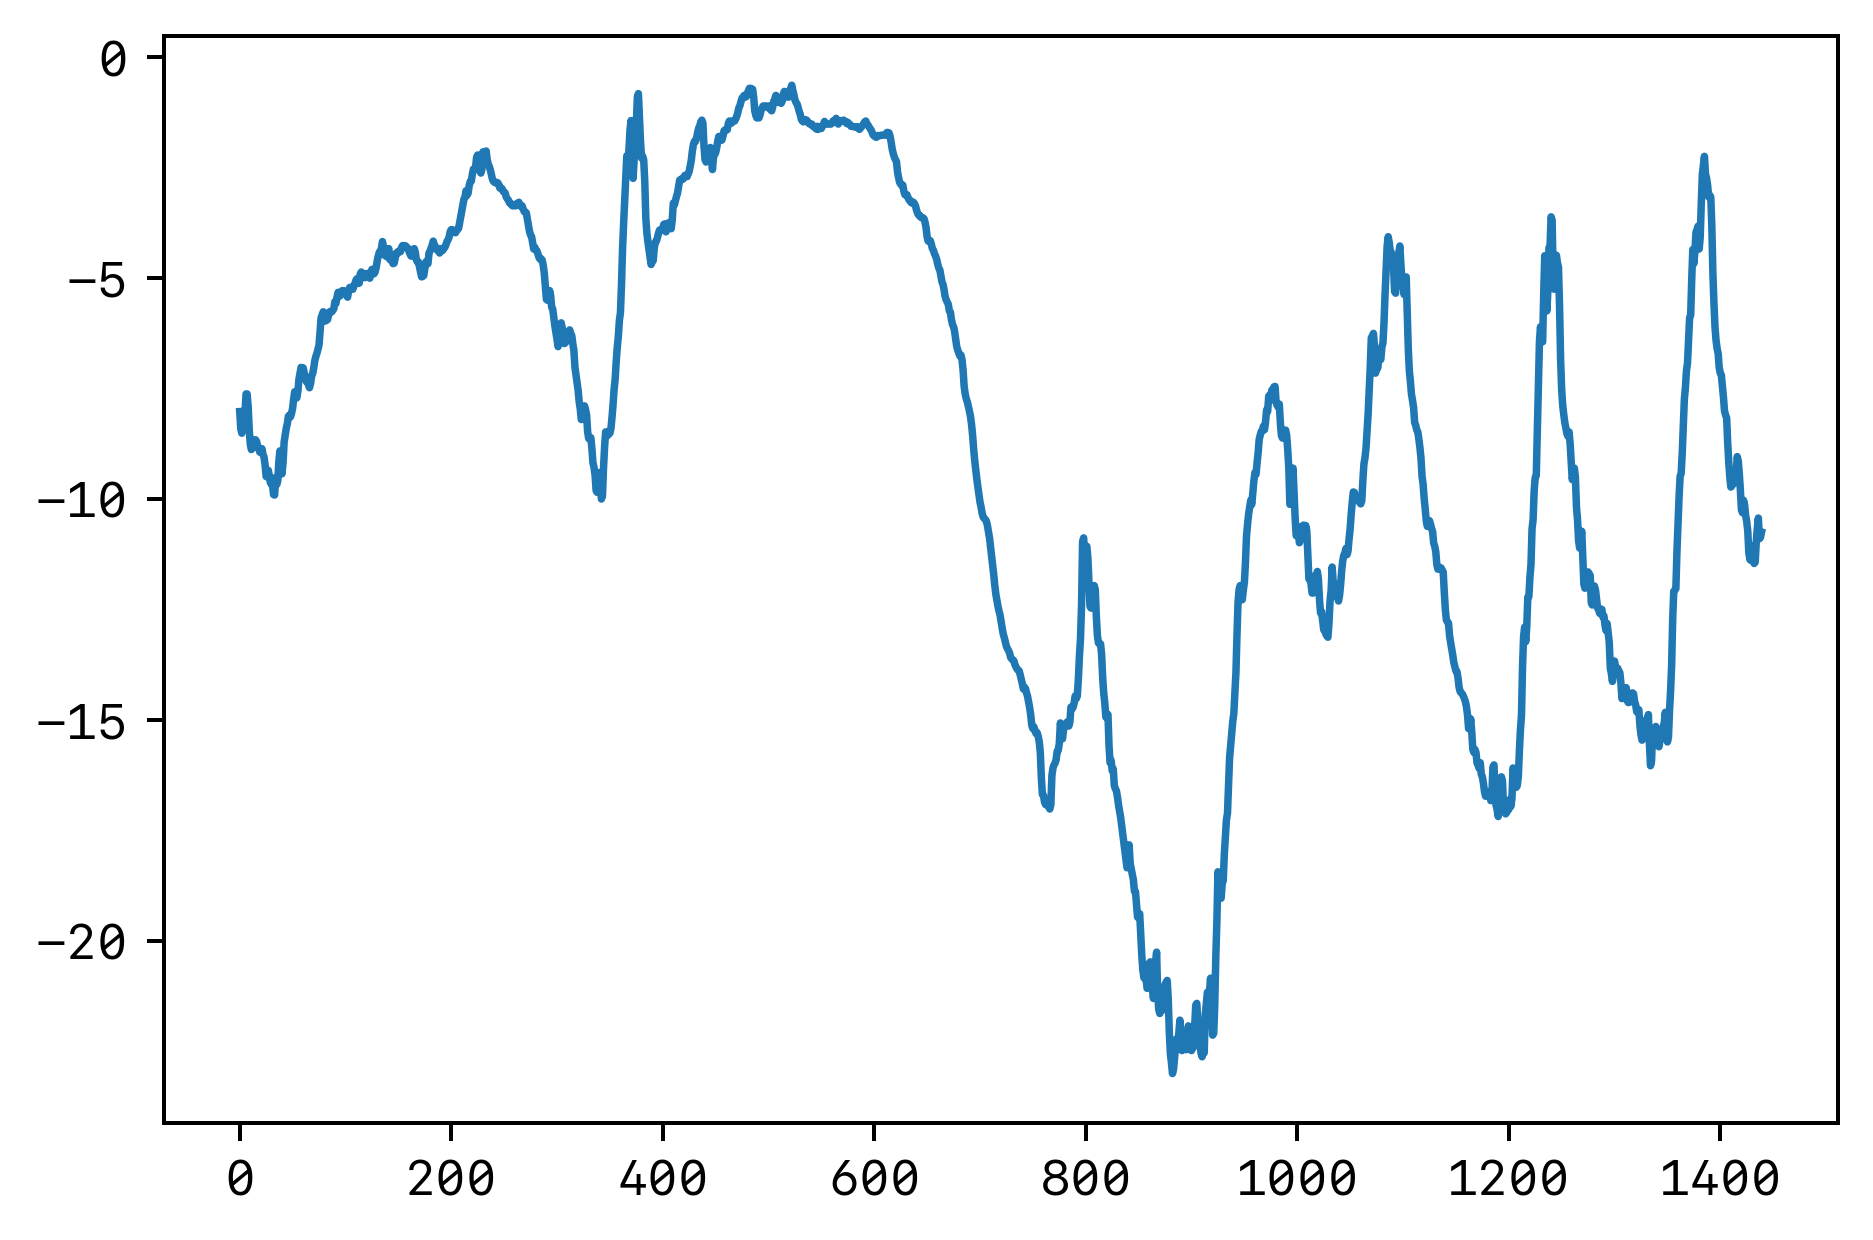

In [15]:
plt.plot(range(1440), temp[:1440])
plt.show()

In [16]:
mean=float_data[:200000].mean(axis=0)
float_data-=mean
std=float_data[:200000].std(axis=0)
float_data/=std


In [17]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [18]:
lookback = 1440
step = 6
delay = 144
batch_size = 16

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

In [19]:
# 为了查看整个验证集，需要 从 val_gen 中抽取多少次
val_steps = (300000 - 200001 - lookback) // batch_size
print(val_steps)
# 为了查看整个测试集，需要从 test_gen 中抽取多少次
test_steps = (len(float_data) - 300001 - lookback) // batch_size
print(test_steps)

6159
7444


In [20]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        # print(samples.shape)
        # (16, 240, 14)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

evaluate_naive_method()

0.2895568298927778


In [23]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
model.summary()





_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3360)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                107552    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)




Epoch 1/20
500/500 [==============================] - 9s 18ms/step - loss: 1.5465 - val_loss: 0.9282

In [30]:
def draw_history(history) :
    plt.rcParams['font.sans-serif'] = ['SF Mono']
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['savefig.dpi'] = 360  #图片像素
    plt.rcParams['figure.dpi'] = 360  #分辨率
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'b', color='red',label='Training loss')
    plt.plot(epochs, val_loss, 'b',color='blue', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

/Users/Bureaux/opt/miniconda3/envs/AI-base/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  # This is added back by InteractiveShellApp.init_path()
/Users/Bureaux/opt/miniconda3/envs/AI-base/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  if sys.path[0] == '':


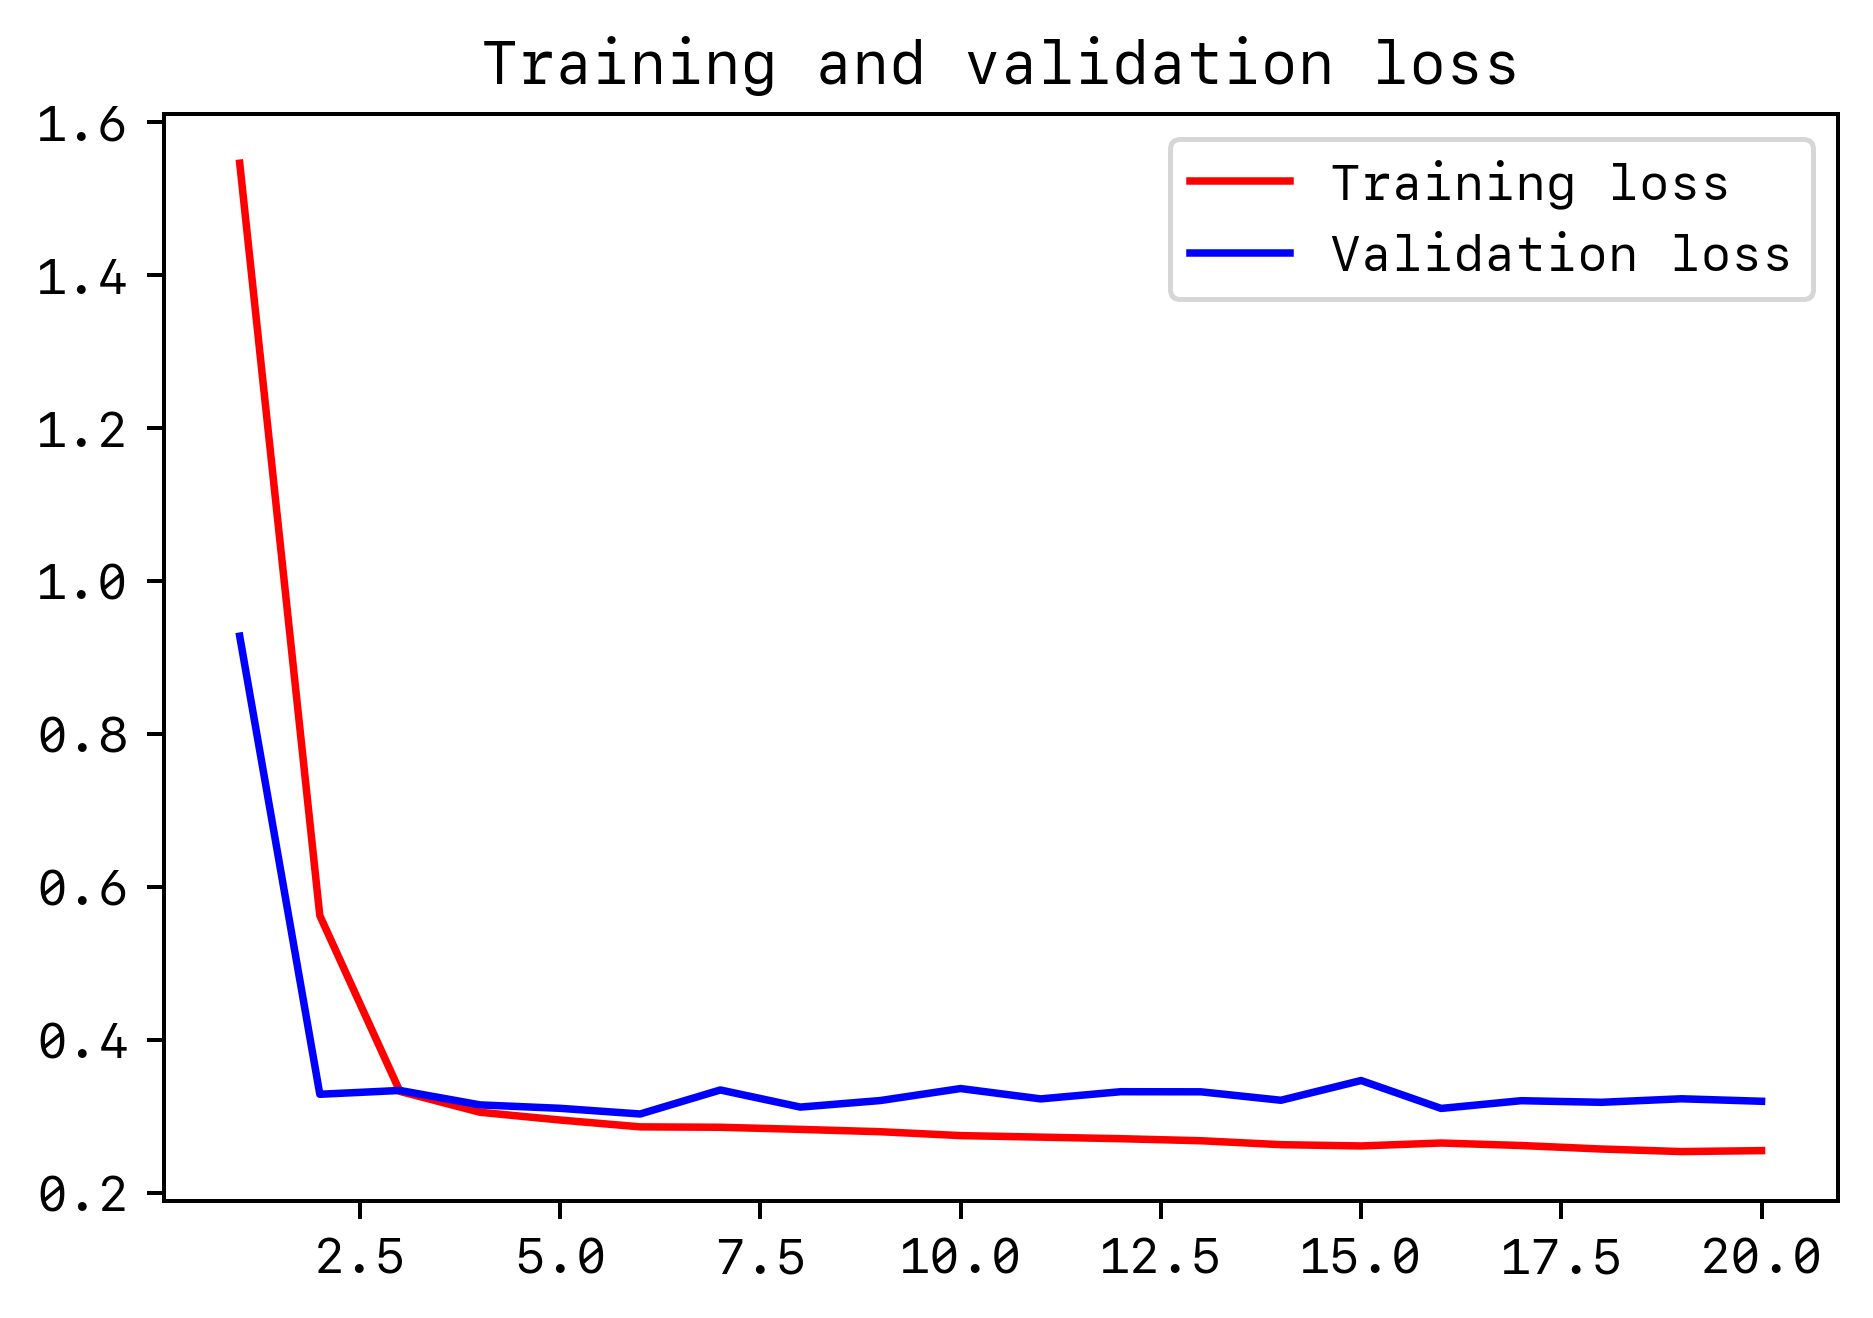

In [31]:
draw_history(history)

In [35]:
model=Sequential()
model.add(layers.GRU(32,input_shape=(None,float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 32)                4512      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


In [36]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
500/500 [==============================] - 144s 288ms/step - loss: 0.3271 - val_loss: 0.2852

/Users/Bureaux/opt/miniconda3/envs/AI-base/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  # This is added back by InteractiveShellApp.init_path()
/Users/Bureaux/opt/miniconda3/envs/AI-base/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  if sys.path[0] == '':


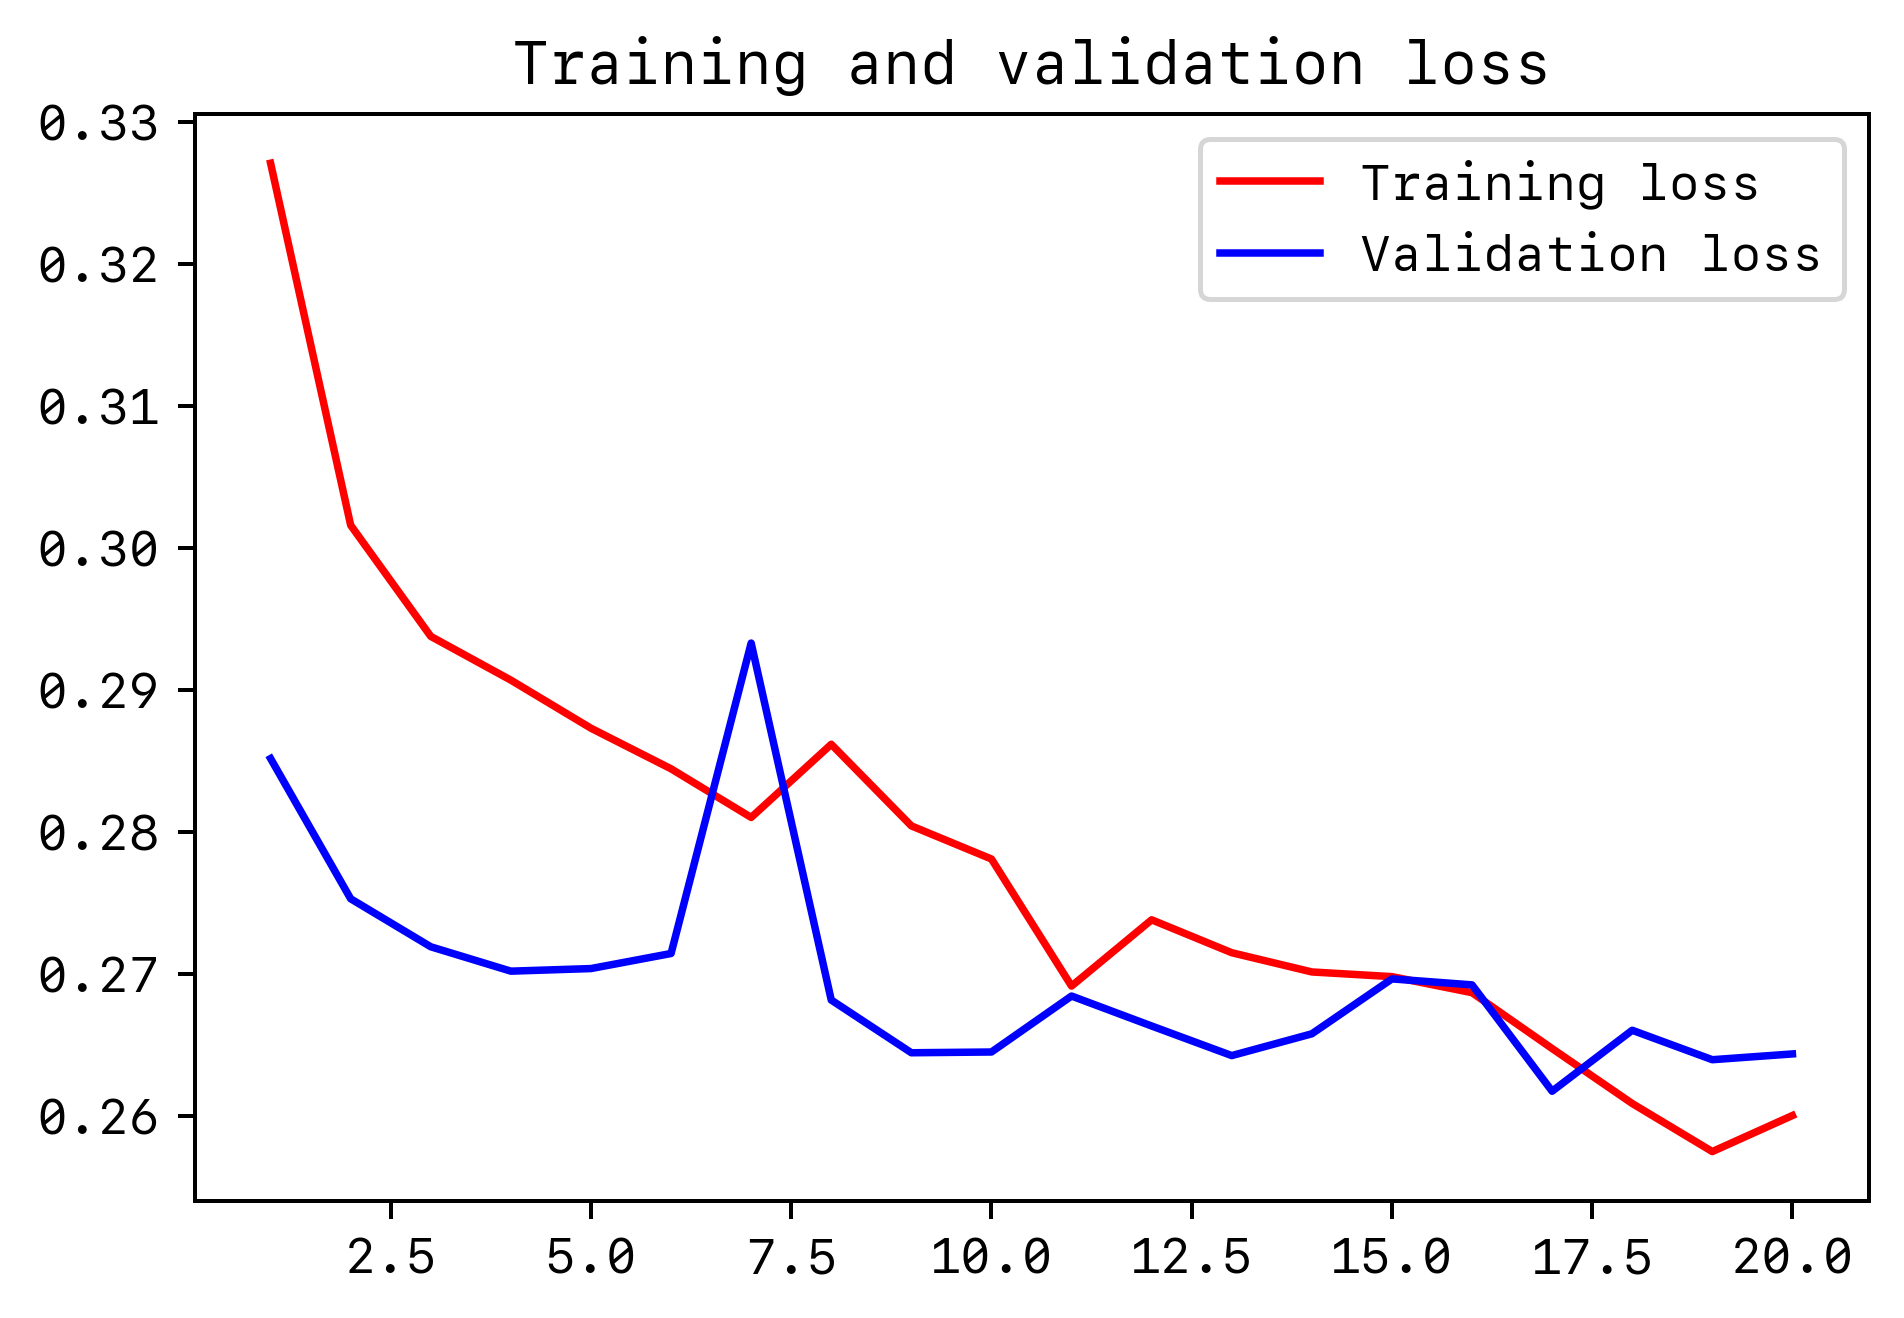

In [37]:
draw_history(history)

In [38]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_5 (GRU)                  (None, None, 32)          4512      
_________________________________________________________________
gru_6 (GRU)                  (None, 64)                18624     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 23,201
Trainable params: 23,201
Non-trainable params: 0
_________________________________________________________________


In [39]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 415s 830ms/step - loss: 0.3573 - val_loss: 0.2882

/Users/Bureaux/opt/miniconda3/envs/AI-base/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  # This is added back by InteractiveShellApp.init_path()
/Users/Bureaux/opt/miniconda3/envs/AI-base/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  if sys.path[0] == '':


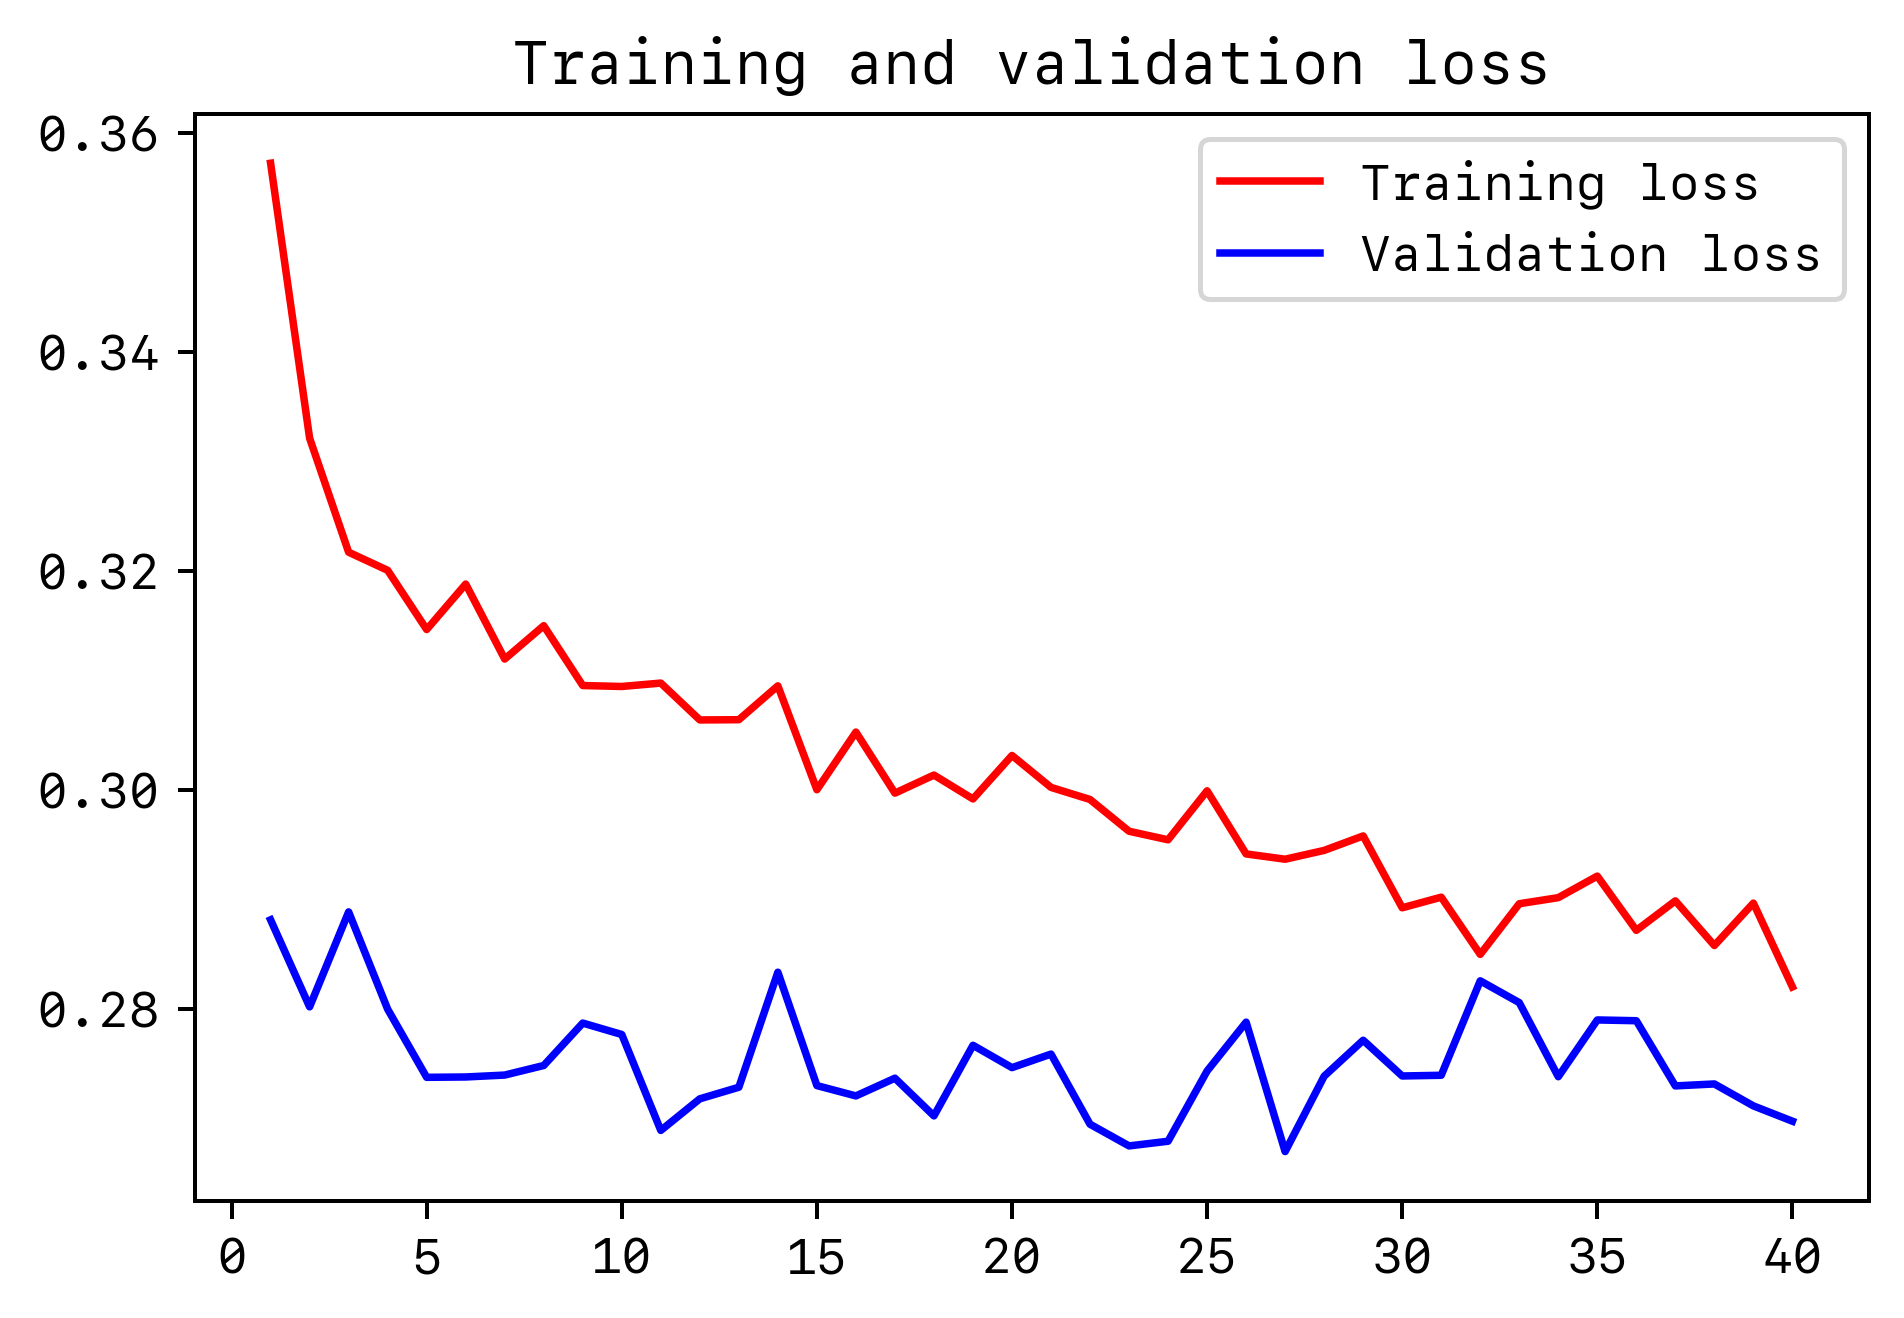

In [40]:
draw_history(history)


In [44]:
K.clear_session()

# Number of words to consider as features（作为特征的单词个数）
max_features = 10000
# Cut texts after this number of words (among top max_features most common words)
# 在这么多单词之后截断文本（这些单词都属于前 max_features 个最常见的单词）
maxlen = 500

# Load data（加载数据）
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print("Padding data:")
print('input_train shape:', x_train.shape)
print('input_test shape:', x_test.shape)


/Users/Bureaux/opt/miniconda3/envs/AI-base/lib/python3.7/site-packages/keras/datasets/imdb.py:101: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/Users/Bureaux/opt/miniconda3/envs/AI-base/lib/python3.7/site-packages/keras/datasets/imdb.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


Padding data:
input_train shape: (25000, 500)
input_test shape: (25000, 500)


In [51]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                16640     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 336,705
Trainable params: 336,705
Non-trainable params: 0
_________________________________________________________________


In [52]:
history=model.fit(
    x_train,y_train,epochs=10,batch_size=32,validation_split=0.2
)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 289s 14ms/step - loss: 0.4328 - acc: 0.8011 - val_loss: 0.3751 - val_acc: 0.8358

/Users/Bureaux/opt/miniconda3/envs/AI-base/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  if sys.path[0] == '':
/Users/Bureaux/opt/miniconda3/envs/AI-base/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  del sys.path[0]
/Users/Bureaux/opt/miniconda3/envs/AI-base/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
/Users/Bureaux/opt/miniconda3/envs/AI-base/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: color is redundantly defined by the 'color' 

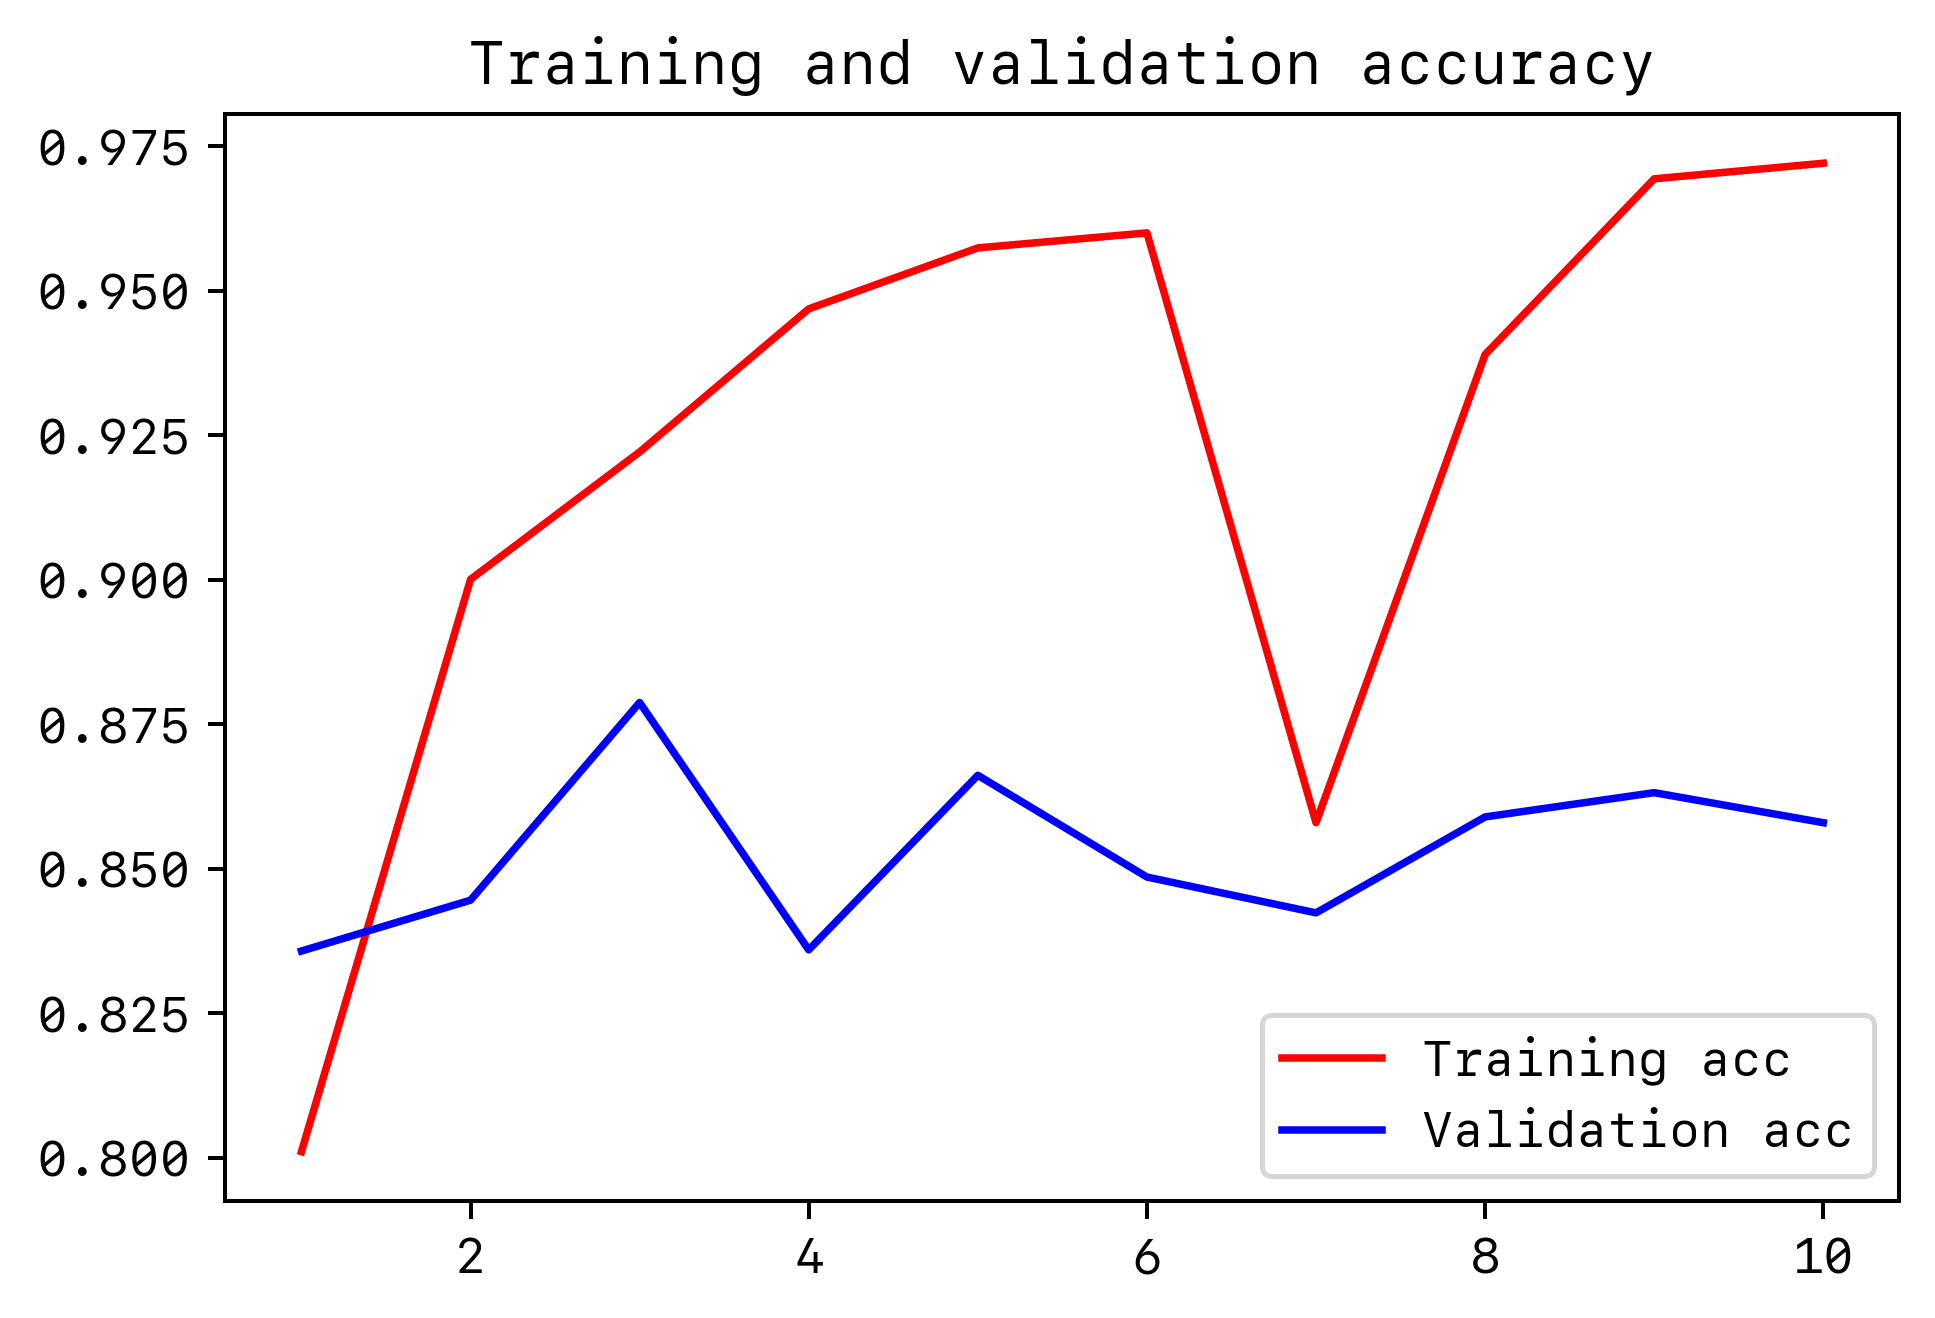

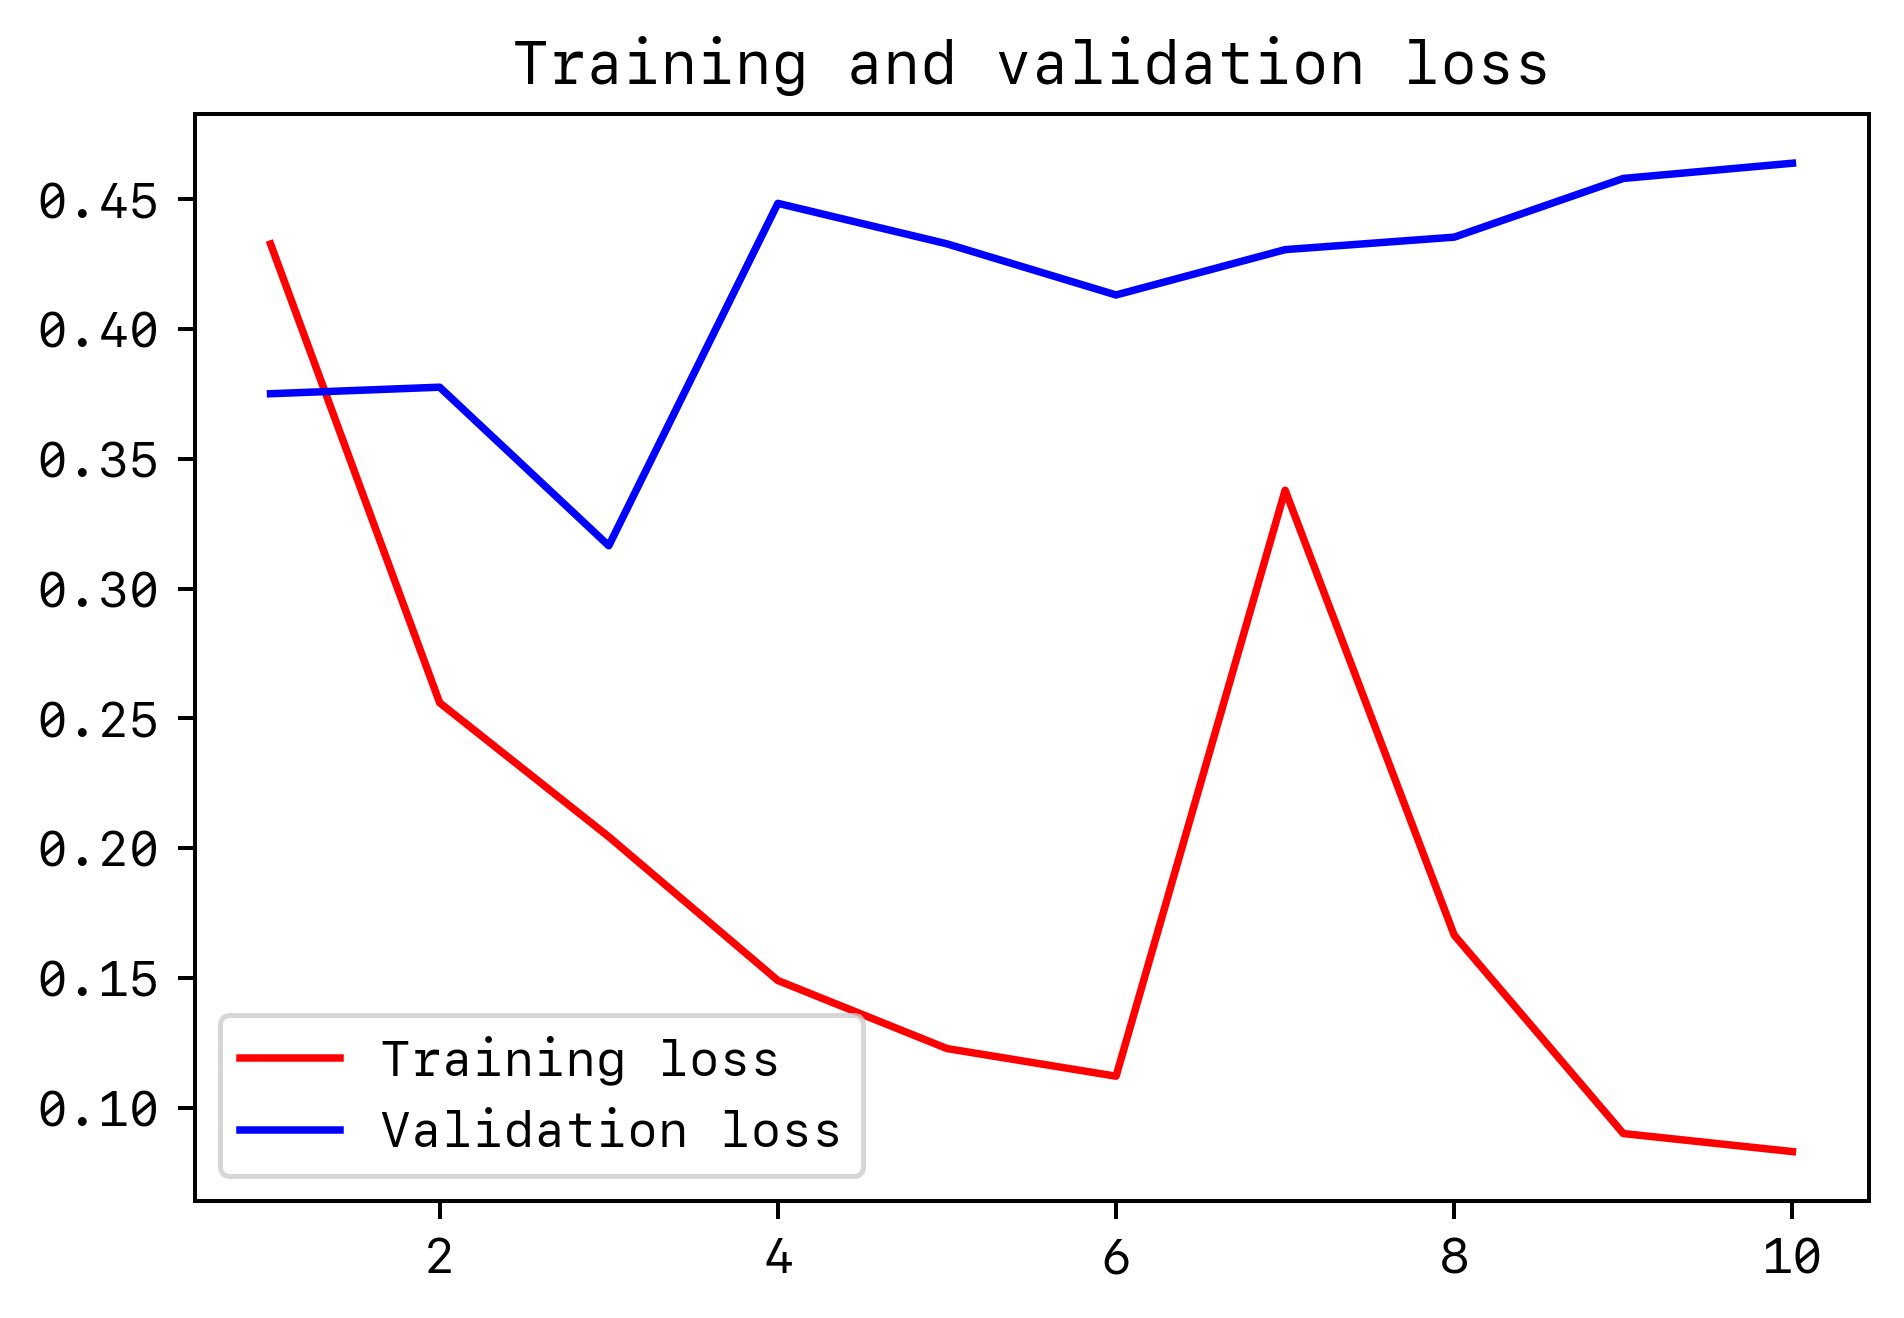

In [53]:
plt.rcParams['font.sans-serif'] = ['SF Mono']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['savefig.dpi'] = 360  #图片像素
plt.rcParams['figure.dpi'] = 360  #分辨率
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b',color='red', label='Training acc')
plt.plot(epochs, val_acc, 'b', color='blue',label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', color='red',label='Training loss')
plt.plot(epochs, val_loss, 'b',color='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()